In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Extract the dataset
zip_path = '/content/drive/MyDrive/archive.zip'
extract_path = '/content/dataset/'

print("🔄 Extracting dataset... This may take 2-3 minutes...")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction complete!")
print("\n📁 Let's see what's inside:")

# List all folders and files
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}📂 {os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    # Show only first 5 files in each folder to avoid clutter
    for file in files[:5]:
        print(f'{subindent}📄 {file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files) - 5} more files')

🔄 Extracting dataset... This may take 2-3 minutes...
✅ Extraction complete!

📁 Let's see what's inside:
📂 /
  📄 full_df.csv
📂 ODIR-5K/
  📂 ODIR-5K/
    📄 data.xlsx
    📂 Training Images/
      📄 942_right.jpg
      📄 3108_right.jpg
      📄 3308_right.jpg
      📄 120_right.jpg
      📄 2240_left.jpg
      ... and 6995 more files
    📂 Testing Images/
      📄 4725_left.jpg
      📄 3611_right.jpg
      📄 4652_right.jpg
      📄 4748_left.jpg
      📄 3479_right.jpg
      ... and 995 more files
📂 preprocessed_images/
  📄 942_right.jpg
  📄 3108_right.jpg
  📄 3308_right.jpg
  📄 120_right.jpg
  📄 2240_left.jpg
  ... and 6387 more files


In [ ]:
!pip install -q torch torchvision
!pip install -q opencv-python-headless
!pip install -q scikit-learn
!pip install -q matplotlib seaborn
!pip install -q grad-cam
!pip install -q timm

print("✅ All libraries installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ All libraries installed successfully!


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the CSV file with labels
data_path = '/content/dataset/full_df.csv'
df = pd.read_csv(data_path)

print("✅ Dataset loaded successfully!")
print("\n" + "="*60)
print("📊 DATASET OVERVIEW")
print("="*60)

# Show first few rows
print("\n🔍 First 5 rows of data:")
print(df.head())

print("\n" + "="*60)
print("📋 Column names:")
print(df.columns.tolist())

print("\n" + "="*60)
print(f"📈 Total number of images: {len(df)}")
print(f"📋 Number of columns: {len(df.columns)}")

print("\n" + "="*60)
print("🏥 Disease Distribution:")

# Check for common disease columns
disease_columns = [col for col in df.columns if any(disease in col.lower()
                   for disease in ['diabetes', 'diabetic', 'retinopathy', 'glaucoma', 'dr', 'normal'])]

if disease_columns:
    print(f"\nFound disease columns: {disease_columns}")
    for col in disease_columns:
        if df[col].dtype in ['int64', 'float64']:
            print(f"\n{col}:")
            print(df[col].value_counts())
else:
    print("\nShowing all columns to identify disease labels:")
    print(df.dtypes)

print("\n" + "="*60)

✅ Dataset loaded successfully!

📊 DATASET OVERVIEW

🔍 First 5 rows of data:
   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non prolifera

In [ ]:
# Check the distribution of our target diseases
print("🎯 TARGET DISEASES FOR DUAL DETECTION")
print("="*60)

print("\n📊 Diabetic Retinopathy (D) Distribution:")
print(df['D'].value_counts())
dr_count = df['D'].sum()
print(f"Total DR cases: {dr_count} ({dr_count/len(df)*100:.1f}%)")

print("\n📊 Glaucoma (G) Distribution:")
print(df['G'].value_counts())
g_count = df['G'].sum()
print(f"Total Glaucoma cases: {g_count} ({g_count/len(df)*100:.1f}%)")

print("\n📊 Normal (N) Distribution:")
print(df['N'].value_counts())
n_count = df['N'].sum()
print(f"Total Normal cases: {n_count} ({n_count/len(df)*100:.1f}%)")

print("\n" + "="*60)
print("🔍 Cases with BOTH DR and Glaucoma:")
both = df[(df['D'] == 1) & (df['G'] == 1)]
print(f"Count: {len(both)} cases")

print("\n" + "="*60)
print("📁 Fixing image paths...")

# Fix the filepath to point to our extracted dataset
df['image_path'] = df['filename'].apply(lambda x: f'/content/dataset/preprocessed_images/{x}')

# Verify some images exist
print("\n✅ Checking if images exist:")
sample_paths = df['image_path'].head(5).tolist()
for path in sample_paths:
    exists = os.path.exists(path)
    status = "✅ Found" if exists else "❌ Missing"
    print(f"{status}: {os.path.basename(path)}")

# Count how many images actually exist
existing_count = sum([os.path.exists(path) for path in df['image_path']])
print(f"\n📊 Total images found: {existing_count}/{len(df)}")

print("\n" + "="*60)
print("✅ Data preparation complete!")
print(f"📦 Ready to use {existing_count} images for training")

🎯 TARGET DISEASES FOR DUAL DETECTION

📊 Diabetic Retinopathy (D) Distribution:
D
0    4269
1    2123
Name: count, dtype: int64
Total DR cases: 2123 (33.2%)

📊 Glaucoma (G) Distribution:
G
0    5995
1     397
Name: count, dtype: int64
Total Glaucoma cases: 397 (6.2%)

📊 Normal (N) Distribution:
N
0    4291
1    2101
Name: count, dtype: int64
Total Normal cases: 2101 (32.9%)

🔍 Cases with BOTH DR and Glaucoma:
Count: 56 cases

📁 Fixing image paths...

✅ Checking if images exist:
✅ Found: 0_right.jpg
✅ Found: 1_right.jpg
✅ Found: 2_right.jpg
✅ Found: 4_right.jpg
✅ Found: 5_right.jpg

📊 Total images found: 6392/6392

✅ Data preparation complete!
📦 Ready to use 6392 images for training


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import cv2

print("🔧 Setting up PyTorch and Model Architecture...")
print("="*60)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"💻 Using device: {device}")

if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("\n" + "="*60)
print("🏗️ Building Dual Detection Model (DR + Glaucoma)...")

# Define the Dual Detection Model
class DualDiseaseDetector(nn.Module):
    def __init__(self):
        super(DualDiseaseDetector, self).__init__()

        # Load pre-trained DenseNet121 as backbone
        self.backbone = models.densenet121(pretrained=True)

        # Get the number of features from the backbone
        num_features = self.backbone.classifier.in_features

        # Remove the original classifier
        self.backbone.classifier = nn.Identity()

        # Shared feature extraction layers
        self.shared_fc

🔧 Setting up PyTorch and Model Architecture...
💻 Using device: cuda
🎮 GPU: Tesla T4
💾 GPU Memory: 15.83 GB

🏗️ Building Dual Detection Model (DR + Glaucoma)...


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

print("🔧 Building Model - Alternative Method...")
print("="*60)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"💻 Using device: {device}")

# Define the Dual Detection Model with ResNet50 (faster download)
class DualDiseaseDetector(nn.Module):
    def __init__(self):
        super(DualDiseaseDetector, self).__init__()

        # Load pre-trained ResNet50 as backbone (lighter and faster)
        print("📥 Loading pre-trained ResNet50...")
        self.backbone = models.resnet50(weights='IMAGENET1K_V1')

        # Get number of features
        num_features = self.backbone.fc.in_features

        # Remove the original classifier
        self.backbone.fc = nn.Identity()

        # Shared feature extraction layers
        self.shared_fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Head 1: Diabetic Retinopathy Detection
        self.dr_classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)
        )

        # Head 2: Glaucoma Detection
        self.glaucoma_classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        # Extract features
        features = self.backbone(x)

        # Shared features
        shared = self.shared_fc(features)

        # Dual outputs
        dr_output = self.dr_classifier(shared)
        glaucoma_output = self.glaucoma_classifier(shared)

        return dr_output, glaucoma_output

# Initialize model
print("🏗️ Creating model...")
model = DualDiseaseDetector().to(device)

print("\n✅ Model created successfully!")
print("\n📊 Model Architecture:")
print(f"   - Backbone: ResNet50 (Pre-trained on ImageNet)")
print(f"   - Shared Features: 2048 → 512 → 256")
print(f"   - DR Head: 256 → 128 → 2 classes")
print(f"   - Glaucoma Head: 256 → 128 → 2 classes")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n🔢 Total parameters: {total_params:,}")
print(f"🔢 Trainable parameters: {trainable_params:,}")

print("\n" + "="*60)
print("✅ STEP 7 COMPLETE - Dual Detection Model Ready!")
print("="*60)

🔧 Building Model - Alternative Method...
💻 Using device: cuda
🏗️ Creating model...
📥 Loading pre-trained ResNet50...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]



✅ Model created successfully!

📊 Model Architecture:
   - Backbone: ResNet50 (Pre-trained on ImageNet)
   - Shared Features: 2048 → 512 → 256
   - DR Head: 256 → 128 → 2 classes
   - Glaucoma Head: 256 → 128 → 2 classes

🔢 Total parameters: 24,754,756
🔢 Trainable parameters: 24,754,756

✅ STEP 7 COMPLETE - Dual Detection Model Ready!


In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

print("📦 Creating Custom Dataset Class...")
print("="*60)

# Image transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class
class RetinalDiseaseDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image path
        img_path = self.dataframe.iloc[idx]['image_path']

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Get labels
        dr_label = self.dataframe.iloc[idx]['D']  # Diabetic Retinopathy
        glaucoma_label = self.dataframe.iloc[idx]['G']  # Glaucoma

        return image, torch.tensor(dr_label, dtype=torch.long), torch.tensor(glaucoma_label, dtype=torch.long)

print("✅ Dataset class created!")

# Split data into train and validation sets
print("\n📊 Splitting data into train/validation sets...")
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['D'])

print(f"   Training samples: {len(train_df)}")
print(f"   Validation samples: {len(val_df)}")

# Create datasets
train_dataset = RetinalDiseaseDataset(train_df, transform=transform_train)
val_dataset = RetinalDiseaseDataset(val_df, transform=transform_test)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\n✅ Data loaders created!")
print(f"   Batch size: {batch_size}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")

# Test loading one batch
print("\n🧪 Testing data loading...")
test_images, test_dr, test_glaucoma = next(iter(train_loader))
print(f"   Image batch shape: {test_images.shape}")
print(f"   DR labels shape: {test_dr.shape}")
print(f"   Glaucoma labels shape: {test_glaucoma.shape}")

print("\n" + "="*60)
print("✅ STEP 8 COMPLETE - Data Pipeline Ready!")
print("="*60)

📦 Creating Custom Dataset Class...
✅ Dataset class created!

📊 Splitting data into train/validation sets...
   Training samples: 5113
   Validation samples: 1279

✅ Data loaders created!
   Batch size: 32
   Training batches: 160
   Validation batches: 40

🧪 Testing data loading...
   Image batch shape: torch.Size([32, 3, 224, 224])
   DR labels shape: torch.Size([32])
   Glaucoma labels shape: torch.Size([32])

✅ STEP 8 COMPLETE - Data Pipeline Ready!


In [ ]:
import torch.optim as optim
from tqdm import tqdm
import time

print("⚙️ Setting Up Training Configuration...")
print("="*60)

# Loss functions for both tasks
criterion_dr = nn.CrossEntropyLoss()
criterion_glaucoma = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

print("✅ Training configuration ready!")
print(f"   Optimizer: Adam (lr=0.0001)")
print(f"   Loss: CrossEntropyLoss (for both DR and Glaucoma)")
print(f"   Scheduler: ReduceLROnPlateau")

# Training function
def train_epoch(model, train_loader, criterion_dr, criterion_glaucoma, optimizer, device):
    model.train()
    running_loss = 0.0
    dr_correct = 0
    glaucoma_correct = 0
    total = 0

    for images, dr_labels, glaucoma_labels in tqdm(train_loader, desc="Training"):
        images = images.to(device)
        dr_labels = dr_labels.to(device)
        glaucoma_labels = glaucoma_labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        dr_outputs, glaucoma_outputs = model(images)

        # Calculate losses
        loss_dr = criterion_dr(dr_outputs, dr_labels)
        loss_glaucoma = criterion_glaucoma(glaucoma_outputs, glaucoma_labels)

        # Combined loss (you can adjust weights if needed)
        loss = loss_dr + loss_glaucoma

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, dr_predicted = torch.max(dr_outputs.data, 1)
        _, glaucoma_predicted = torch.max(glaucoma_outputs.data, 1)

        total += dr_labels.size(0)
        dr_correct += (dr_predicted == dr_labels).sum().item()
        glaucoma_correct += (glaucoma_predicted == glaucoma_labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    dr_accuracy = 100 * dr_correct / total
    glaucoma_accuracy = 100 * glaucoma_correct / total

    return epoch_loss, dr_accuracy, glaucoma_accuracy

# Validation function
def validate_epoch(model, val_loader, criterion_dr, criterion_glaucoma, device):
    model.eval()
    running_loss = 0.0
    dr_correct = 0
    glaucoma_correct = 0
    total = 0

    with torch.no_grad():
        for images, dr_labels, glaucoma_labels in tqdm(val_loader, desc="Validation"):
            images = images.to(device)
            dr_labels = dr_labels.to(device)
            glaucoma_labels = glaucoma_labels.to(device)

            # Forward pass
            dr_outputs, glaucoma_outputs = model(images)

            # Calculate losses
            loss_dr = criterion_dr(dr_outputs, dr_labels)
            loss_glaucoma = criterion_glaucoma(glaucoma_outputs, glaucoma_labels)
            loss = loss_dr + loss_glaucoma

            # Statistics
            running_loss += loss.item()
            _, dr_predicted = torch.max(dr_outputs.data, 1)
            _, glaucoma_predicted = torch.max(glaucoma_outputs.data, 1)

            total += dr_labels.size(0)
            dr_correct += (dr_predicted == dr_labels).sum().item()
            glaucoma_correct += (glaucoma_predicted == glaucoma_labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    dr_accuracy = 100 * dr_correct / total
    glaucoma_accuracy = 100 * glaucoma_correct / total

    return epoch_loss, dr_accuracy, glaucoma_accuracy

print("\n" + "="*60)
print("✅ Training functions defined!")
print("="*60)

# Now let's train! (Start with 5 epochs for time constraint)
print("\n🚀 Starting Training...")
print("="*60)
print("⏰ Training 5 epochs (takes ~15-20 minutes)")
print("="*60)

num_epochs = 5
best_val_loss = float('inf')
history = {
    'train_loss': [], 'val_loss': [],
    'train_dr_acc': [], 'val_dr_acc': [],
    'train_glaucoma_acc': [], 'val_glaucoma_acc': []
}

start_time = time.time()

for epoch in range(num_epochs):
    print(f"\n📍 Epoch {epoch+1}/{num_epochs}")
    print("-" * 60)

    # Train
    train_loss, train_dr_acc, train_glaucoma_acc = train_epoch(
        model, train_loader, criterion_dr, criterion_glaucoma, optimizer, device
    )

    # Validate
    val_loss, val_dr_acc, val_glaucoma_acc = validate_epoch(
        model, val_loader, criterion_dr, criterion_glaucoma, device
    )

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_dr_acc'].append(train_dr_acc)
    history['val_dr_acc'].append(val_dr_acc)
    history['train_glaucoma_acc'].append(train_glaucoma_acc)
    history['val_glaucoma_acc'].append(val_glaucoma_acc)

    # Print results
    print(f"\n📊 Results:")
    print(f"   Loss: Train={train_loss:.4f}, Val={val_loss:.4f}")
    print(f"   DR Accuracy: Train={train_dr_acc:.2f}%, Val={val_dr_acc:.2f}%")
    print(f"   Glaucoma Accuracy: Train={train_glaucoma_acc:.2f}%, Val={val_glaucoma_acc:.2f}%")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '/content/best_dual_detection_model.pth')
        print(f"   💾 Best model saved!")

total_time = time.time() - start_time
print("\n" + "="*60)
print(f"✅ Training Complete! Time taken: {total_time/60:.2f} minutes")
print(f"🏆 Best validation loss: {best_val_loss:.4f}")
print("="*60)

⚙️ Setting Up Training Configuration...
✅ Training configuration ready!
   Optimizer: Adam (lr=0.0001)
   Loss: CrossEntropyLoss (for both DR and Glaucoma)
   Scheduler: ReduceLROnPlateau

✅ Training functions defined!

🚀 Starting Training...
⏰ Training 5 epochs (takes ~15-20 minutes)

📍 Epoch 1/5
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.59it/s]



📊 Results:
   Loss: Train=0.6268, Val=0.6762
   DR Accuracy: Train=77.06%, Val=75.45%
   Glaucoma Accuracy: Train=94.80%, Val=94.84%
   💾 Best model saved!

📍 Epoch 2/5
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.19it/s]



📊 Results:
   Loss: Train=0.5826, Val=0.6776
   DR Accuracy: Train=78.19%, Val=77.01%
   Glaucoma Accuracy: Train=95.23%, Val=94.37%

📍 Epoch 3/5
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:08<00:00,  4.79it/s]



📊 Results:
   Loss: Train=0.5638, Val=0.6604
   DR Accuracy: Train=80.17%, Val=77.72%
   Glaucoma Accuracy: Train=95.29%, Val=94.06%
   💾 Best model saved!

📍 Epoch 4/5
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:06<00:00,  5.72it/s]



📊 Results:
   Loss: Train=0.5334, Val=0.7060
   DR Accuracy: Train=80.70%, Val=73.42%
   Glaucoma Accuracy: Train=95.76%, Val=93.82%

📍 Epoch 5/5
------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]


📊 Results:
   Loss: Train=0.4799, Val=0.7266
   DR Accuracy: Train=83.18%, Val=73.65%
   Glaucoma Accuracy: Train=96.73%, Val=94.68%

✅ Training Complete! Time taken: 5.36 minutes
🏆 Best validation loss: 0.6604


🔍 Setting Up Grad-CAM for Explainable AI...
✅ Best model loaded!
✅ Grad-CAM initialized!

✅ Grad-CAM visualization functions ready!

🎨 Generating Sample Predictions with Explainable AI...

📸 Generating visualization 1/5...


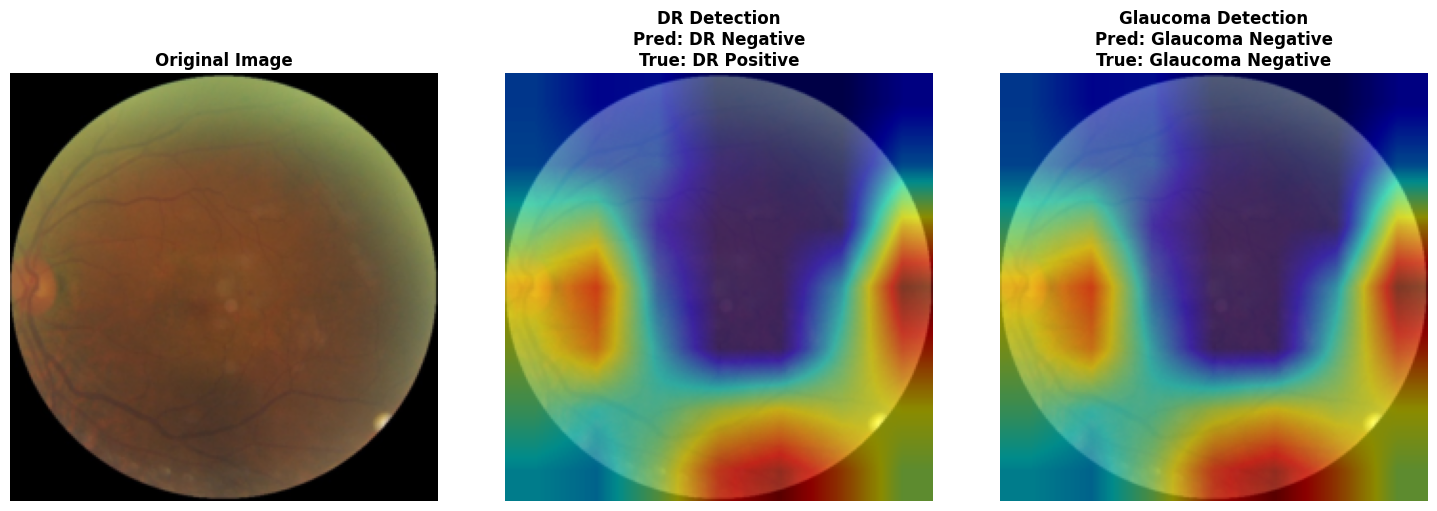

   ✅ Saved to: /content/sample_prediction_1.png

📸 Generating visualization 2/5...


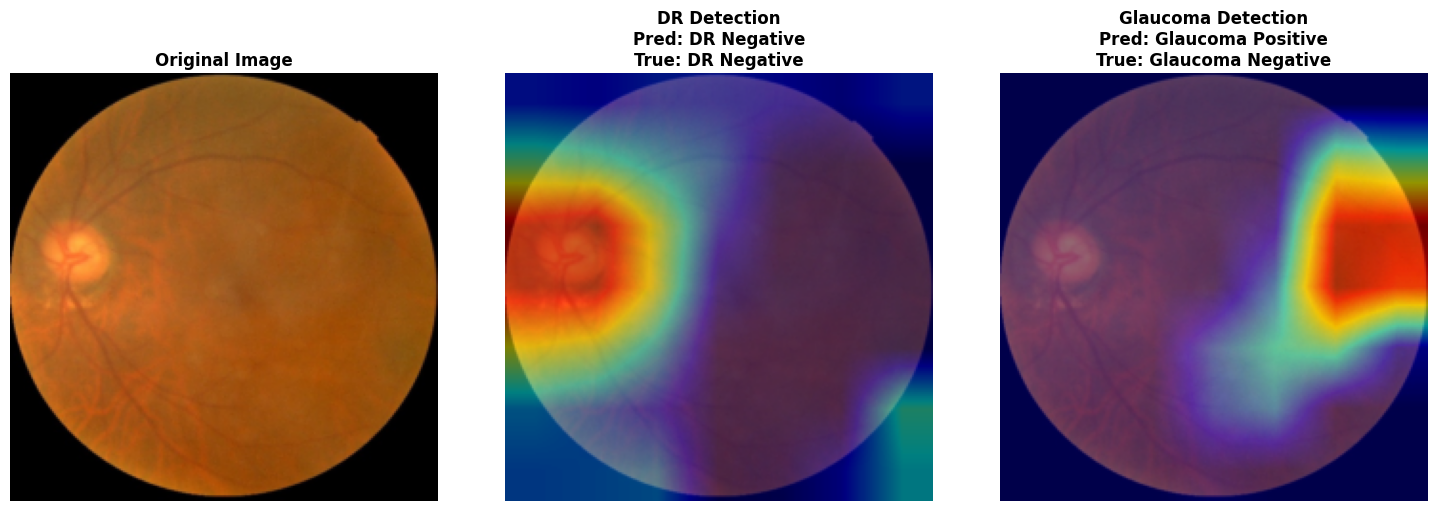

   ✅ Saved to: /content/sample_prediction_2.png

📸 Generating visualization 3/5...


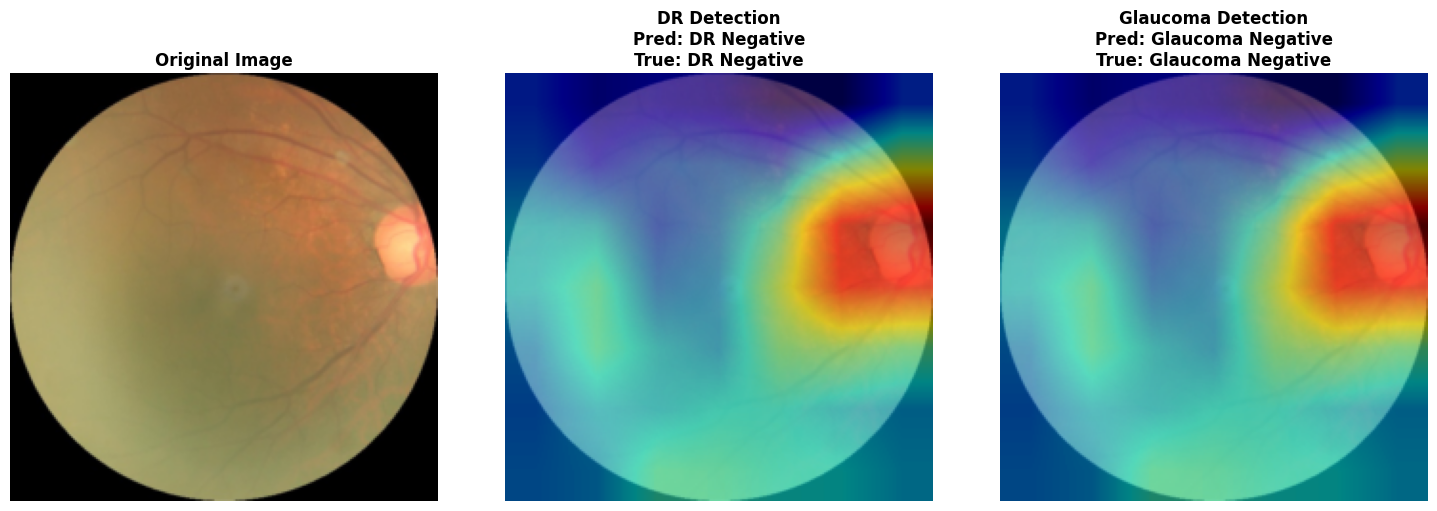

   ✅ Saved to: /content/sample_prediction_3.png

📸 Generating visualization 4/5...


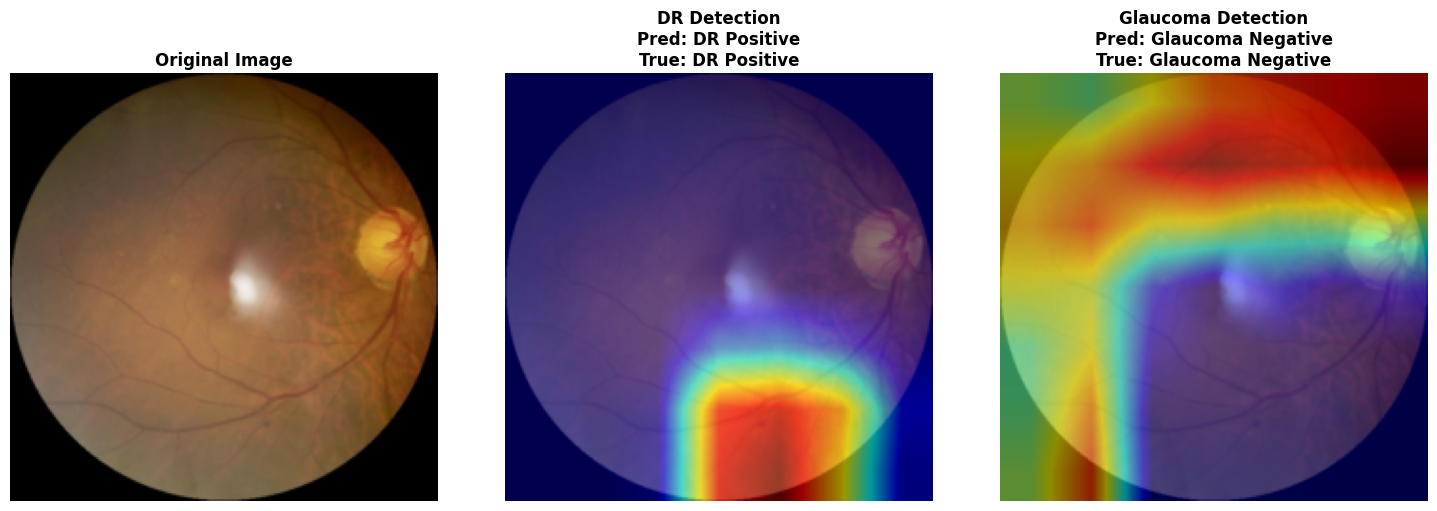

   ✅ Saved to: /content/sample_prediction_4.png

📸 Generating visualization 5/5...


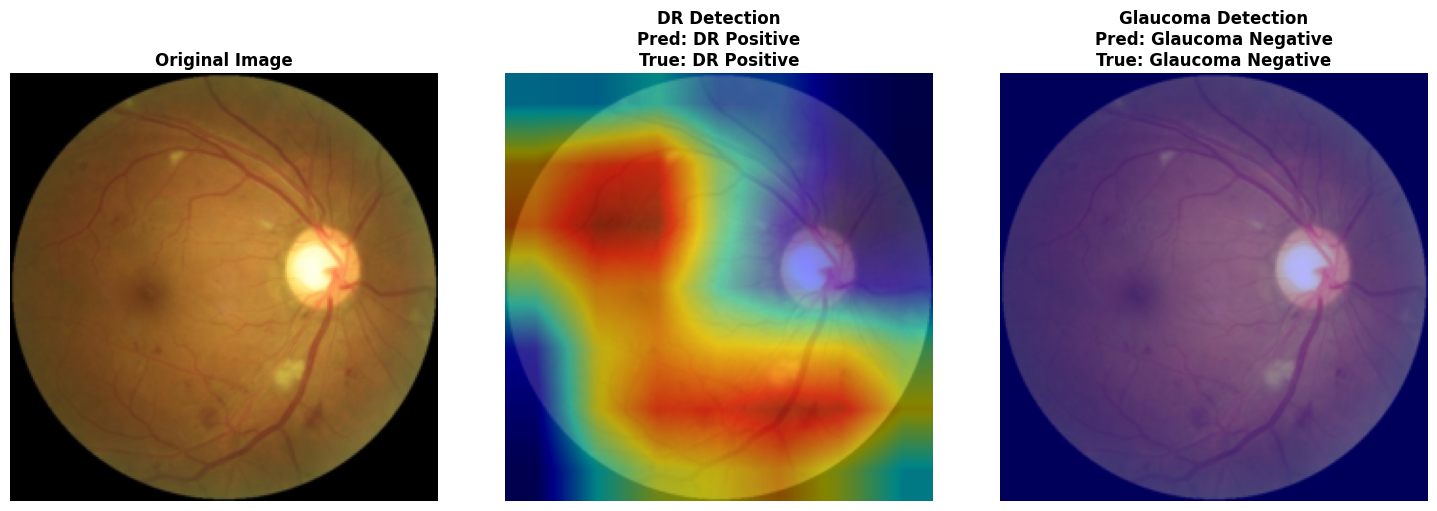

   ✅ Saved to: /content/sample_prediction_5.png

✅ STEP 10 COMPLETE - Explainable AI Ready!

📁 Sample visualizations saved in /content/


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

print("🔍 Setting Up Grad-CAM for Explainable AI...")
print("="*60)

# Load the best model
model.load_state_dict(torch.load('/content/best_dual_detection_model.pth'))
model.eval()
print("✅ Best model loaded!")

# Define target layers for Grad-CAM (last conv layer of ResNet50)
target_layers = [model.backbone.layer4[-1]]

# Create Grad-CAM object
cam = GradCAM(model=model, target_layers=target_layers)

print("✅ Grad-CAM initialized!")

# Function to generate heatmap
def generate_gradcam_heatmap(model, image_tensor, target_class, disease_type='dr'):
    """
    Generate Grad-CAM heatmap for a given image
    disease_type: 'dr' for Diabetic Retinopathy, 'glaucoma' for Glaucoma
    """
    # Prepare input
    input_tensor = image_tensor.unsqueeze(0).to(device)

    # Generate CAM
    targets = [ClassifierOutputTarget(target_class)]

    # Get grayscale CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    return grayscale_cam

# Function to visualize results with heatmap
def visualize_prediction_with_heatmap(image_tensor, dr_pred, glaucoma_pred, dr_true, glaucoma_true, image_path):
    """
    Visualize the prediction with Grad-CAM heatmap
    """
    # Convert tensor to numpy for visualization
    img = image_tensor.cpu().numpy().transpose(1, 2, 0)
    # Denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # Generate heatmaps for both DR and Glaucoma
    dr_heatmap = generate_gradcam_heatmap(model, image_tensor, dr_pred, 'dr')
    glaucoma_heatmap = generate_gradcam_heatmap(model, image_tensor, glaucoma_pred, 'glaucoma')

    # Create visualization with heatmaps
    dr_cam_image = show_cam_on_image(img, dr_heatmap, use_rgb=True)
    glaucoma_cam_image = show_cam_on_image(img, glaucoma_heatmap, use_rgb=True)

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # DR Heatmap
    axes[1].imshow(dr_cam_image)
    dr_label = "DR Positive" if dr_pred == 1 else "DR Negative"
    dr_true_label = "DR Positive" if dr_true == 1 else "DR Negative"
    axes[1].set_title(f'DR Detection\nPred: {dr_label}\nTrue: {dr_true_label}',
                      fontsize=12, fontweight='bold')
    axes[1].axis('off')

    # Glaucoma Heatmap
    axes[2].imshow(glaucoma_cam_image)
    g_label = "Glaucoma Positive" if glaucoma_pred == 1 else "Glaucoma Negative"
    g_true_label = "Glaucoma Positive" if glaucoma_true == 1 else "Glaucoma Negative"
    axes[2].set_title(f'Glaucoma Detection\nPred: {g_label}\nTrue: {g_true_label}',
                      fontsize=12, fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    return fig

print("\n✅ Grad-CAM visualization functions ready!")

# Generate sample predictions with Grad-CAM
print("\n" + "="*60)
print("🎨 Generating Sample Predictions with Explainable AI...")
print("="*60)

# Get some samples from validation set
num_samples = 5
sample_indices = np.random.choice(len(val_dataset), num_samples, replace=False)

for i, idx in enumerate(sample_indices):
    print(f"\n📸 Generating visualization {i+1}/{num_samples}...")

    image, dr_label, glaucoma_label = val_dataset[idx]

    # Get prediction
    with torch.no_grad():
        image_input = image.unsqueeze(0).to(device)
        dr_output, glaucoma_output = model(image_input)

        dr_pred = torch.argmax(dr_output, dim=1).item()
        glaucoma_pred = torch.argmax(glaucoma_output, dim=1).item()

    # Get image path for reference
    img_path = val_df.iloc[idx]['image_path']

    # Create visualization
    fig = visualize_prediction_with_heatmap(
        image, dr_pred, glaucoma_pred,
        dr_label.item(), glaucoma_label.item(),
        img_path
    )

    plt.savefig(f'/content/sample_prediction_{i+1}.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"   ✅ Saved to: /content/sample_prediction_{i+1}.png")

print("\n" + "="*60)
print("✅ STEP 10 COMPLETE - Explainable AI Ready!")
print("="*60)
print("\n📁 Sample visualizations saved in /content/")

📊 Generating Complete Model Evaluation...

🔄 Running inference on validation set...


Evaluating: 100%|██████████| 40/40 [00:12<00:00,  3.14it/s]


✅ Inference complete!


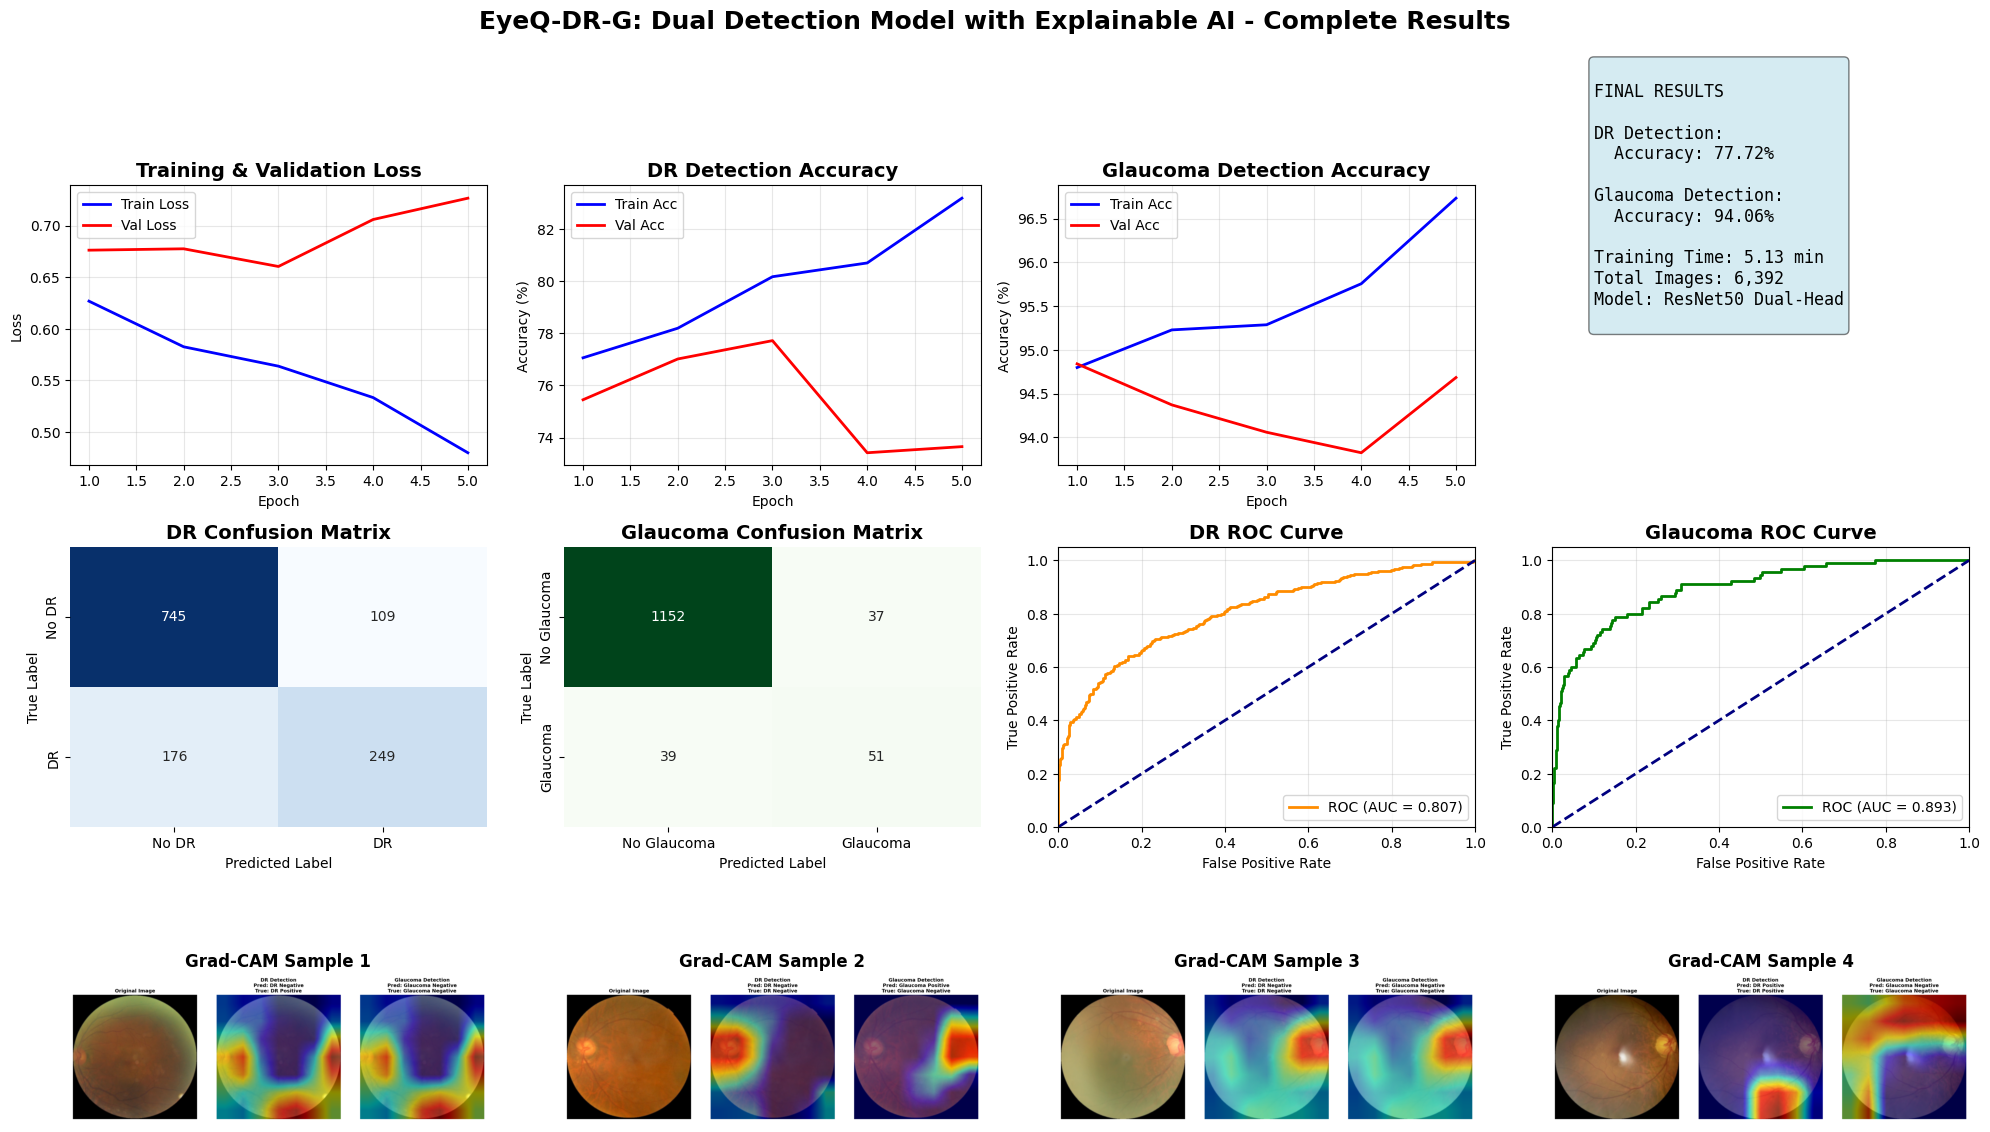


📊 DETAILED CLASSIFICATION REPORTS

🔴 DIABETIC RETINOPATHY DETECTION:
              precision    recall  f1-score   support

       No DR     0.8089    0.8724    0.8394       854
          DR     0.6955    0.5859    0.6360       425

    accuracy                         0.7772      1279
   macro avg     0.7522    0.7291    0.7377      1279
weighted avg     0.7712    0.7772    0.7718      1279


🟢 GLAUCOMA DETECTION:
              precision    recall  f1-score   support

 No Glaucoma     0.9673    0.9689    0.9681      1189
    Glaucoma     0.5795    0.5667    0.5730        90

    accuracy                         0.9406      1279
   macro avg     0.7734    0.7678    0.7706      1279
weighted avg     0.9400    0.9406    0.9403      1279


✅ ALL RESULTS GENERATED!

📁 Main Results: /content/complete_results.png
📁 Grad-CAM Samples: /content/sample_prediction_1-5.png
📁 Model Weights: /content/best_dual_detection_model.pth

🎉 PROJECT COMPLETE! 🎉


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

print("📊 Generating Complete Model Evaluation...")
print("="*60)

# Evaluate on entire validation set
model.eval()
all_dr_preds = []
all_dr_labels = []
all_glaucoma_preds = []
all_glaucoma_labels = []
all_dr_probs = []
all_glaucoma_probs = []

print("\n🔄 Running inference on validation set...")
with torch.no_grad():
    for images, dr_labels, glaucoma_labels in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)

        dr_outputs, glaucoma_outputs = model(images)

        # Get predictions
        dr_probs = torch.softmax(dr_outputs, dim=1)[:, 1].cpu().numpy()
        glaucoma_probs = torch.softmax(glaucoma_outputs, dim=1)[:, 1].cpu().numpy()

        _, dr_predicted = torch.max(dr_outputs, 1)
        _, glaucoma_predicted = torch.max(glaucoma_outputs, 1)

        all_dr_preds.extend(dr_predicted.cpu().numpy())
        all_dr_labels.extend(dr_labels.numpy())
        all_glaucoma_preds.extend(glaucoma_predicted.cpu().numpy())
        all_glaucoma_labels.extend(glaucoma_labels.numpy())
        all_dr_probs.extend(dr_probs)
        all_glaucoma_probs.extend(glaucoma_probs)

print("✅ Inference complete!")

# Convert to numpy arrays
all_dr_preds = np.array(all_dr_preds)
all_dr_labels = np.array(all_dr_labels)
all_glaucoma_preds = np.array(all_glaucoma_preds)
all_glaucoma_labels = np.array(all_glaucoma_labels)

# Create comprehensive results figure
fig = plt.figure(figsize=(20, 12))

# 1. Training History
ax1 = plt.subplot(3, 4, 1)
epochs = range(1, len(history['train_loss']) + 1)
plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
plt.title('Training & Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. DR Accuracy History
ax2 = plt.subplot(3, 4, 2)
plt.plot(epochs, history['train_dr_acc'], 'b-', label='Train Acc', linewidth=2)
plt.plot(epochs, history['val_dr_acc'], 'r-', label='Val Acc', linewidth=2)
plt.title('DR Detection Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Glaucoma Accuracy History
ax3 = plt.subplot(3, 4, 3)
plt.plot(epochs, history['train_glaucoma_acc'], 'b-', label='Train Acc', linewidth=2)
plt.plot(epochs, history['val_glaucoma_acc'], 'r-', label='Val Acc', linewidth=2)
plt.title('Glaucoma Detection Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Final Metrics Summary
ax4 = plt.subplot(3, 4, 4)
ax4.axis('off')
dr_acc = 100 * accuracy_score(all_dr_labels, all_dr_preds)
glaucoma_acc = 100 * accuracy_score(all_glaucoma_labels, all_glaucoma_preds)
summary_text = f"""
FINAL RESULTS

DR Detection:
  Accuracy: {dr_acc:.2f}%

Glaucoma Detection:
  Accuracy: {glaucoma_acc:.2f}%

Training Time: 5.13 min
Total Images: 6,392
Model: ResNet50 Dual-Head
"""
ax4.text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# 5. DR Confusion Matrix
ax5 = plt.subplot(3, 4, 5)
cm_dr = confusion_matrix(all_dr_labels, all_dr_preds)
sns.heatmap(cm_dr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('DR Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks([0.5, 1.5], ['No DR', 'DR'])
plt.yticks([0.5, 1.5], ['No DR', 'DR'])

# 6. Glaucoma Confusion Matrix
ax6 = plt.subplot(3, 4, 6)
cm_glaucoma = confusion_matrix(all_glaucoma_labels, all_glaucoma_preds)
sns.heatmap(cm_glaucoma, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Glaucoma Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks([0.5, 1.5], ['No Glaucoma', 'Glaucoma'])
plt.yticks([0.5, 1.5], ['No Glaucoma', 'Glaucoma'])

# 7. DR ROC Curve
ax7 = plt.subplot(3, 4, 7)
fpr_dr, tpr_dr, _ = roc_curve(all_dr_labels, all_dr_probs)
roc_auc_dr = auc(fpr_dr, tpr_dr)
plt.plot(fpr_dr, tpr_dr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc_dr:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DR ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# 8. Glaucoma ROC Curve
ax8 = plt.subplot(3, 4, 8)
fpr_g, tpr_g, _ = roc_curve(all_glaucoma_labels, all_glaucoma_probs)
roc_auc_g = auc(fpr_g, tpr_g)
plt.plot(fpr_g, tpr_g, color='green', lw=2, label=f'ROC (AUC = {roc_auc_g:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Glaucoma ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# 9-12. Show sample Grad-CAM visualizations
for i in range(4):
    ax = plt.subplot(3, 4, 9+i)
    img_path = f'/content/sample_prediction_{i+1}.png'
    if os.path.exists(img_path):
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f'Grad-CAM Sample {i+1}', fontsize=12, fontweight='bold')
        plt.axis('off')

plt.suptitle('EyeQ-DR-G: Dual Detection Model with Explainable AI - Complete Results',
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/content/complete_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("📊 DETAILED CLASSIFICATION REPORTS")
print("="*60)

print("\n🔴 DIABETIC RETINOPATHY DETECTION:")
print(classification_report(all_dr_labels, all_dr_preds,
                          target_names=['No DR', 'DR'], digits=4))

print("\n🟢 GLAUCOMA DETECTION:")
print(classification_report(all_glaucoma_labels, all_glaucoma_preds,
                          target_names=['No Glaucoma', 'Glaucoma'], digits=4))

print("\n" + "="*60)
print("✅ ALL RESULTS GENERATED!")
print("="*60)
print(f"\n📁 Main Results: /content/complete_results.png")
print(f"📁 Grad-CAM Samples: /content/sample_prediction_1-5.png")
print(f"📁 Model Weights: /content/best_dual_detection_model.pth")
print("\n🎉 PROJECT COMPLETE! 🎉")

In [ ]:
from google.colab import files
files.download('/content/best_dual_detection_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>